In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [11]:
data = pd.read_csv('data/MN997409.1-4NY0T82X016-Alignment-HitTable.csv')

In [13]:
data.head()

,MN997409.1,MN997409.1.1,100.000,29882,0,0.1,1,29882.1,1.1,29882.2,0.0,55182
0,MN997409.1,MT020881.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
1,MN997409.1,MT020880.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
2,MN997409.1,MN985325.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
3,MN997409.1,MN975262.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
4,MN997409.1,LC522974.1,99.993,29878,2,0,4,29881,1,29878,0.0,55164


In [14]:
data = data.rename(columns={"MN997409.1": "query acc.ver", "MN997409.1.1": "subject acc.ver",
                            "100.000":"% identity","29882":"alignment length","0":"mismatches",
                            "0.1":"gap opens","1":"q. start","29882.1":"q. end","1.1":"s. start",
                           "29882.2	":"s. end","0.0":"evalue","55182":"bit score"})

In [16]:
data.head()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,29882.2,evalue,bit score
0,MN997409.1,MT020881.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
1,MN997409.1,MT020880.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
2,MN997409.1,MN985325.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
3,MN997409.1,MN975262.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
4,MN997409.1,LC522974.1,99.993,29878,2,0,4,29881,1,29878,0.0,55164


In [17]:
data = data.append(pd.Series(['MN997409.1',	'MN997409.1.1',	
                    100.000,	29882,	
                    0,	0.1,	1,	29882.1,	
                    1.1,	29882.2,	0.0,	55182], index=data.columns), ignore_index=True)

In [18]:
data.tail()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,29882.2,evalue,bit score
258,MN997409.1,AY282752.2,82.304,17716,2948,169.0,3956,21577.0,3868.0,21490.0,0.0,15175
259,MN997409.1,AY282752.2,80.063,5417,988,68.0,22539,27910.0,22414.0,27783.0,0.0,3936
260,MN997409.1,AY282752.2,90.189,1641,142,12.0,28257,29882.0,28088.0,29724.0,0.0,2121
261,MN997409.1,AY282752.2,79.305,1928,358,35.0,16,1923.0,1.0,1907.0,0.0,1312
262,MN997409.1,MN997409.1.1,100.000,29882,0,0.1,1,29882.1,1.1,29882.2,0.0,55182


In [20]:
data.shape

(263, 12)

In [21]:
data.describe()

,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,29882.2,evalue,bit score
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.0,263.00000
mean,86.064958,10711.114068,919.235741,57.821673,11295.684411,21970.517490,11212.646768,21888.837262,0.0,14240.34981
std,7.609654,10530.955700,1085.784789,60.654416,12022.056513,10652.171126,11963.759134,10619.704332,0.0,19226.72192
min,77.559000,1603.000000,0.000000,0.000000,1.000000,1923.000000,1.000000,1672.000000,0.0,1011.00000
25%,80.048000,1925.000000,142.000000,12.000000,16.000000,21577.000000,1.050000,21489.000000,0.0,2101.00000
50%,82.304000,5417.000000,359.000000,35.000000,3956.000000,27910.000000,3875.000000,27783.000000,0.0,3936.00000
75%,90.189000,17716.000000,989.000000,68.000000,22539.000000,29875.500000,22429.000000,29729.000000,0.0,15175.00000
max,100.000000,29882.000000,2952.000000,172.000000,28257.000000,29882.100000,28137.000000,30256.000000,0.0,55182.00000


In [22]:
data.corr()

,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,29882.2,evalue,bit score
% identity,1.000000,0.631524,-0.453509,-0.535174,-0.052519,0.566794,-0.051870,0.569653,NaN,0.793438
alignment length,0.631524,1.000000,0.206680,0.136714,-0.560720,0.355570,-0.560761,0.359521,NaN,0.944639
mismatches,-0.453509,0.206680,1.000000,0.988180,-0.197306,-0.021370,-0.198956,-0.022302,NaN,-0.125766
gap opens,-0.535174,0.136714,0.988180,1.000000,-0.183218,-0.074691,-0.184789,-0.075778,NaN,-0.193213
q. start,-0.052519,-0.560720,-0.197306,-0.183218,1.000000,0.574516,0.999987,0.571028,NaN,-0.502689
q. end,0.566794,0.355570,-0.021370,-0.074691,0.574516,1.000000,0.574465,0.999974,NaN,0.367344
s. start,-0.051870,-0.560761,-0.198956,-0.184789,0.999987,0.574465,1.000000,0.571007,NaN,-0.502181
29882.2,0.569653,0.359521,-0.022302,-0.075778,0.571028,0.999974,0.571007,1.000000,NaN,0.371660
evalue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bit score,0.793438,0.944639,-0.125766,-0.193213,-0.502689,0.367344,-0.502181,0.371660,NaN,1.000000


Text(0.5, 1.0, 'Correlation between different fearures')

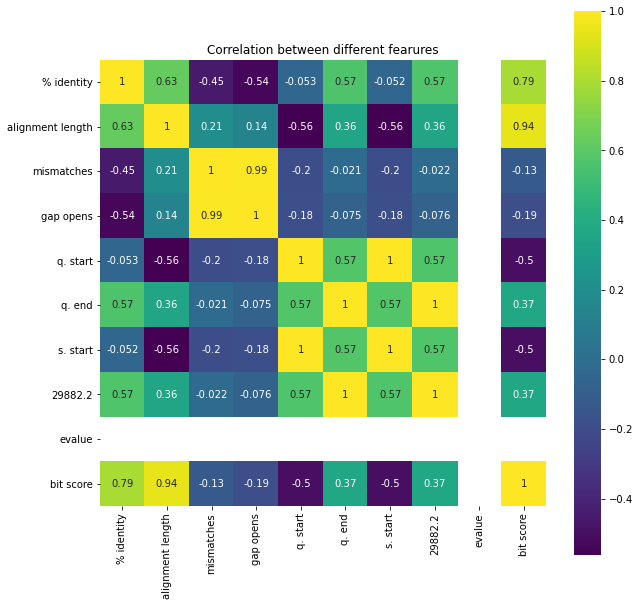

In [23]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation between different fearures')

# k-Means Clustering

In [24]:
from sklearn.cluster import KMeans

In [25]:
data['subject acc.ver'] = data['subject acc.ver'].astype("category").cat.codes

In [26]:
data.head()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,29882.2,evalue,bit score
0,MN997409.1,86,99.990,29882,3,0.0,1,29882.0,1.0,29882.0,0.0,55166
1,MN997409.1,85,99.990,29882,3,0.0,1,29882.0,1.0,29882.0,0.0,55166
2,MN997409.1,66,99.990,29882,3,0.0,1,29882.0,1.0,29882.0,0.0,55166
3,MN997409.1,65,99.990,29882,3,0.0,1,29882.0,1.0,29882.0,0.0,55166
4,MN997409.1,55,99.993,29878,2,0.0,4,29881.0,1.0,29878.0,0.0,55164


In [27]:
X = data.iloc[:,1:].values

## Using Silhouette Score for Evaluating Clusters

In [28]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [29]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(X)
print(standardized_data.shape)

(263, 11)


For n_clusters = 2 The average silhouette_score is : 0.6051456304424346
For n_clusters = 3 The average silhouette_score is : 0.7737574709178652
For n_clusters = 4 The average silhouette_score is : 0.9304299438199628
For n_clusters = 5 The average silhouette_score is : 0.9626586534510194
For n_clusters = 6 The average silhouette_score is : 0.9625756535242549
For n_clusters = 7 The average silhouette_score is : 0.9585239650538647
For n_clusters = 8 The average silhouette_score is : 0.9614207899227608
For n_clusters = 9 The average silhouette_score is : 0.9626169262248866
For n_clusters = 10 The average silhouette_score is : 0.9644636830559539


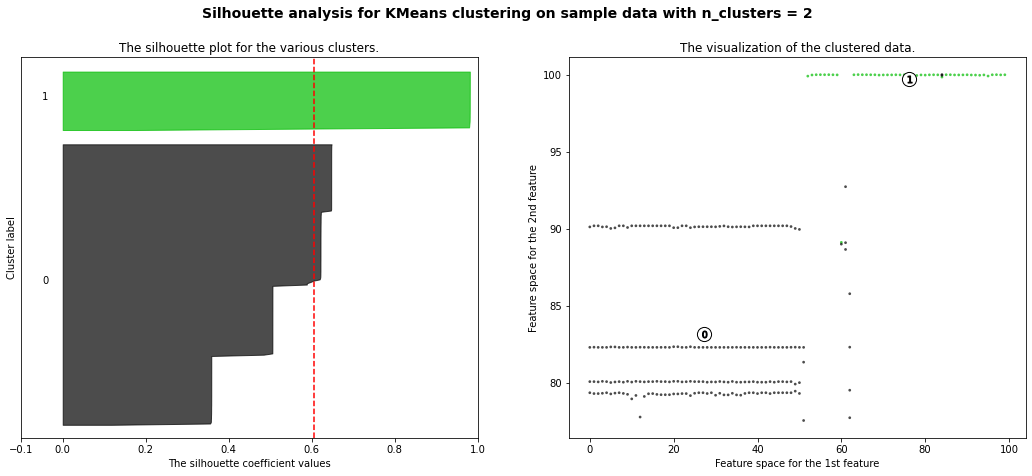

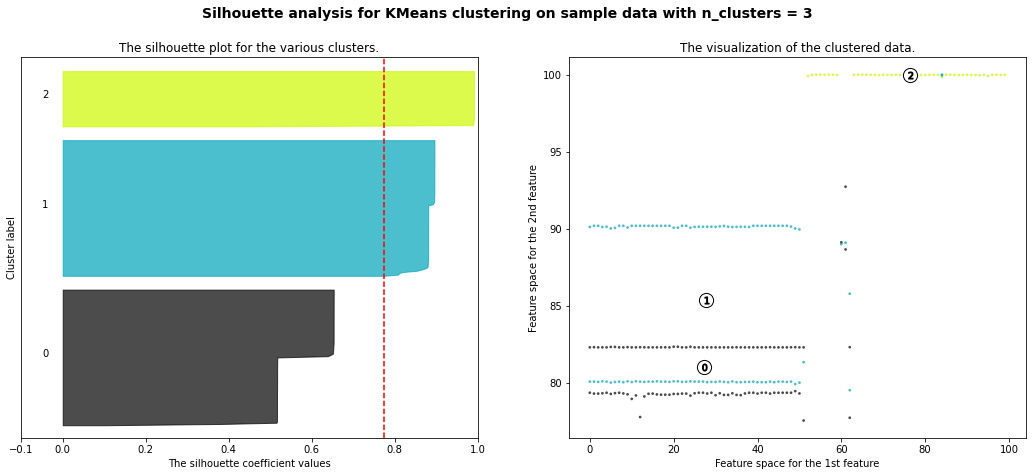

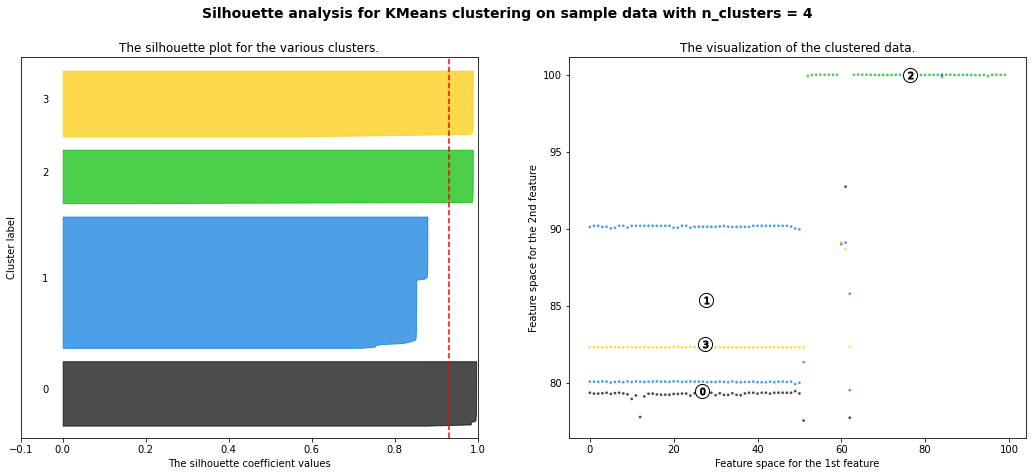

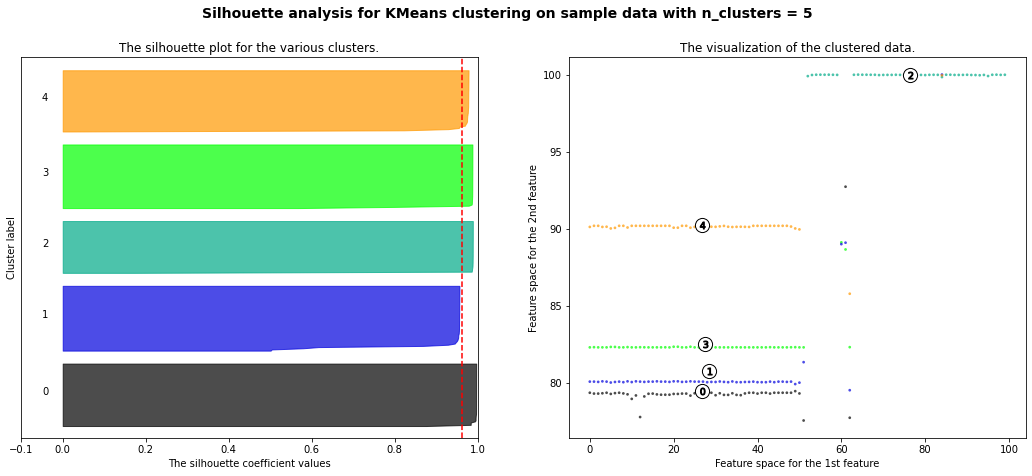

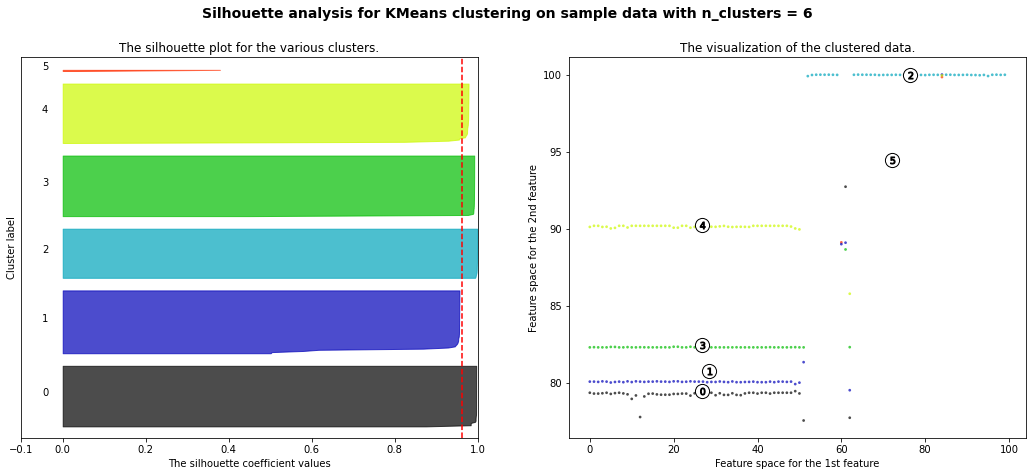

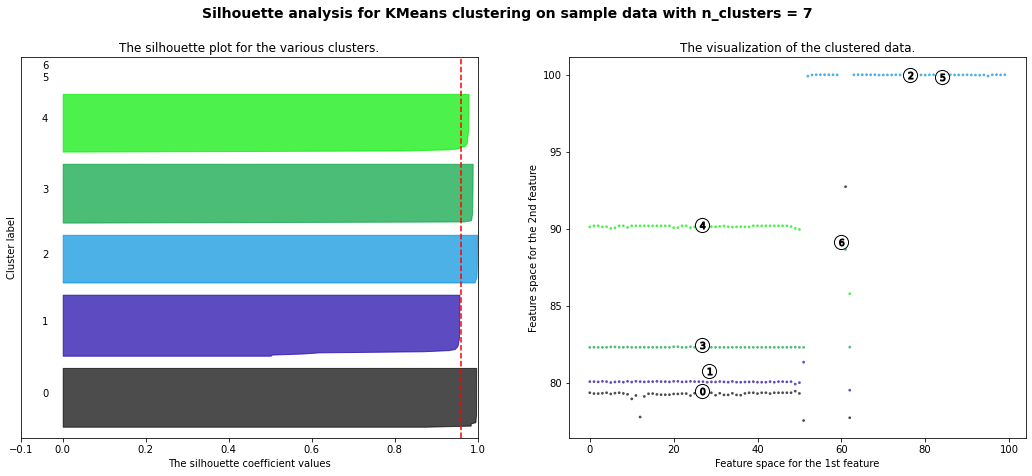

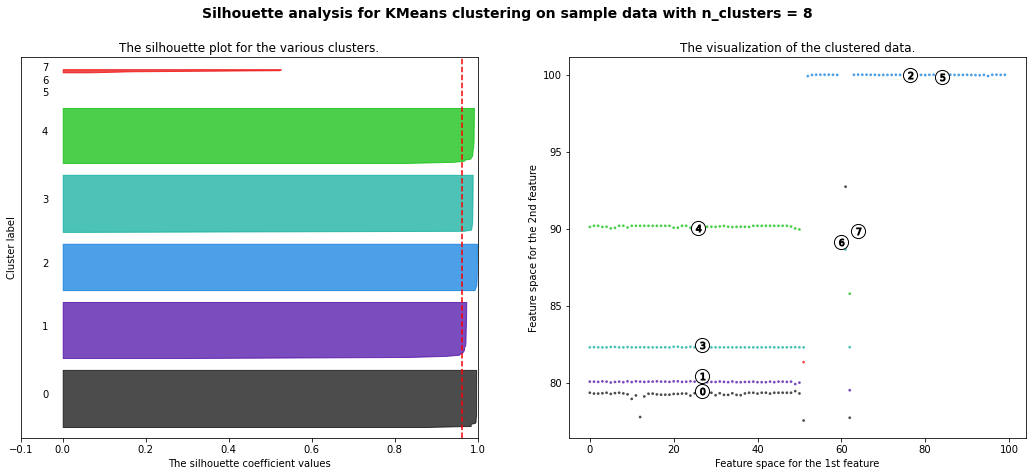

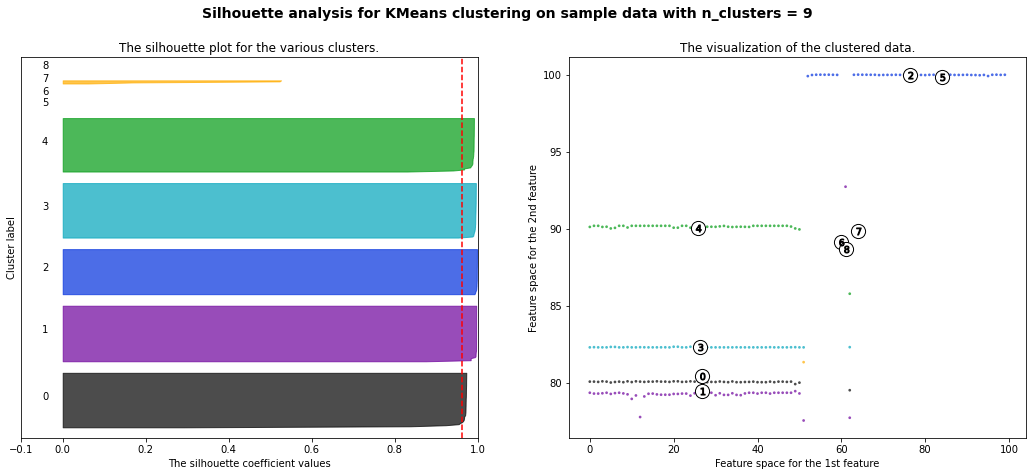

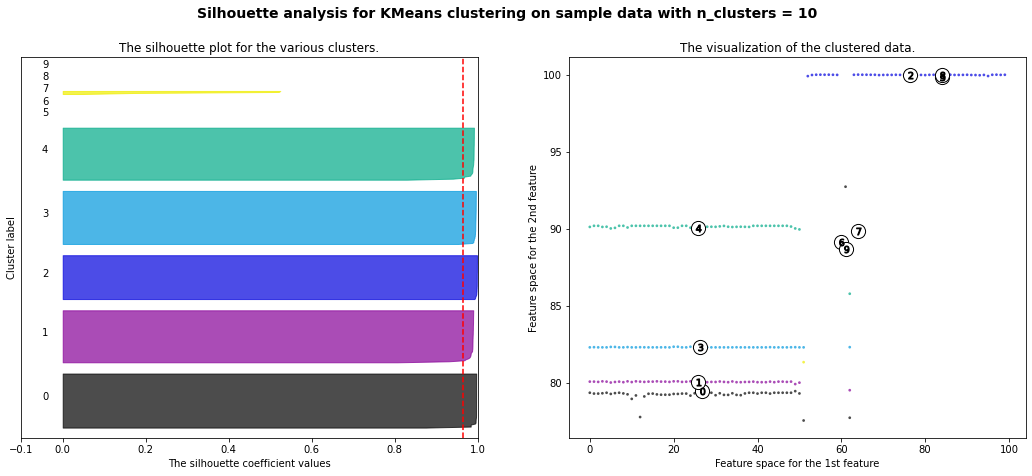

In [30]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

## PCA Visualization

In [31]:
covar_matrix = np.matmul(standardized_data.T , standardized_data)

In [32]:
covar_matrix.shape

(11, 11)

In [33]:
from scipy.linalg import eigh 

In [34]:
#top2 eigenvalue
values, vectors = eigh(covar_matrix, eigvals=(9,10))

In [35]:
vectors.shape

(11, 2)

In [36]:
#transpose
vectors = vectors.T
vectors.shape

(2, 11)

In [37]:
new_coordinates = np.matmul(vectors, standardized_data.T)
print ("Resultant at new data shape: ", vectors.shape, "*", standardized_data.T.shape," = ", new_coordinates.shape)

Resultant at new data shape:  (2, 11) * (11, 263)  =  (2, 263)


In [38]:
new_coordinates = np.vstack((new_coordinates)).T

df = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal"))
print(df.head())

   1st_principal  2nd_principal
0      -0.811932      -4.340659
1      -0.808541      -4.324404
2      -0.744119      -4.015558
3      -0.740728      -3.999302
4      -0.706546      -3.836705


C:\Users\Thilina\.conda\envs\MScDM2020\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


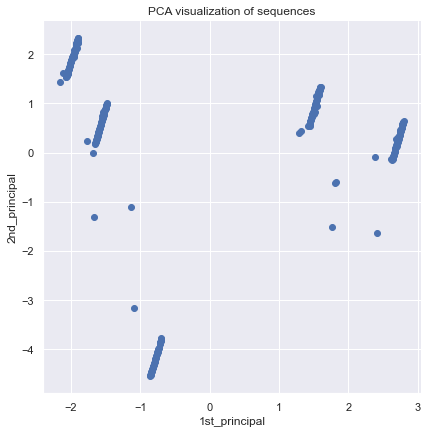

In [39]:
sns.set()
sns.FacetGrid(df, size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.title('PCA visualization of sequences')
plt.show()

In [11]:
from Bio.Seq import Seq

In [14]:
sq = Seq('ATCGCCCAATAACGCGCAAGACTGCT')

In [16]:
tsq = sq.transcribe()

In [18]:
prt = tsq.translate()

C:\Users\Thilina\.conda\envs\MScDM2020\lib\site-packages\Bio\Seq.py:2338: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [19]:
prt

Seq('IAQ*RARL')

In [24]:
bat_genome_file = open(r'data/BAT_SARS_LIKE_coronavirus_complete_genome_sequence.fasta', 'r')

bg_pre_1 = bat_genome_file.read()

bat_genome_file.close()

In [32]:
bg_pre_2 = bg_pre_1[69:]
bg_pre_3 = bg_pre_2.replace('\n', '')

In [34]:
bg_pre_3

'ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTAGCTGTCGCTCGGCTGCATGCCTAGTGCACCTACGCAGTATAAACAATAATAAATTTTACTGTCGTTGACAAGAAACGAGTAACTCGTCCCTCTTCTGCAGACTGCTTACGGTTTCGTCCGTGTTGCAGTCGATCATCAGCATACCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTTCTTGGTGTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTCTTCAGGTTAGAGACGTGCTAGTGCGTGGCTTCGGGGACTCCGTGGAAGAGGCCCTATCGGAGGCACGTGAACATCTTAAAAATGGCACTTGTGGTTTAGTAGAGCTGGAAAAAGGCGTACTGCCCCAGCTTGAACAGCCCTATGTGTTCATTAAACGTTCTGATGCCTTAAGCACCAATCACGGCCACAAGGTCGTAGAGCTGGTTGCAGAATTGGATGGCGTTCAGTACGGTCGTAGCGGTATAACTCTGGGAGTGCTCGTGCCACATGTGGGCGAAACCCCAATCGCATACCGCAATGTTCTTCTTCGTAAGAACGGTAATAAGGGAGCCGGTGGCCATAGCTTTGGCATCGATCTAAAGTCTTATGACTTAGGTGACGAGCTTGGCACTGATCCCATTGAAGATTATGAACAAAACTGGAACACTAAGCATGGCAGTGGTGCACTCCGTGAACTCACTCGTGAGCTCAATGGAGGTGCAGTCACTCGCTATGTCGACAACAACTTCTGTGGCCCAGATGGGTACCCTCTTGATTGCATCAAAGATTTTCTCGCTCGCGCGGGTAAGTCAATGTGCACTCTTTCTGAACAACTTGATTACATCGAGTCGAAGAGAGGTGTCTACTGCTGCCGTGACCATGATCATGAAATTGCCTGGTTCACTGAGCGCTCT

In [35]:
from Bio import SeqIO

In [36]:
rec = SeqIO.read('data/BAT_SARS_LIKE_coronavirus_complete_genome_sequence.fasta', 'fasta')

In [61]:
rec.seq

Seq('ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGA...AAA')